In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import torchmetrics
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, GenerationConfig
import os
import pandas as pd

np.random.seed(42)

In [2]:
torch.cuda.is_available()

True

In [3]:
# Hyperparamters 
top_k = 50
top_p = 0.9
temp = 0.8
min_new_tokens = 10
max_new_tokens = 50
do_sample=True
num_beams=1

dataset_name="PubMedQA"
model_name= "facebook/opt-1.3b"
batch_size=8
max_input_length=2048
DEVICE = "cuda:2" if torch.cuda.is_available() else "cpu"
access_token = ""
cache_dir="/data/james/.cache"

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, BertTokenizer

class Evaluator:
    def __init__(self, metrics=None):
        if not metrics:
            metrics = ["rouge", "sacre_bleu", "bertscore", "factkb"]
        self.metrics = metrics
    
    def evaluate(self, predictions, references, documents, metrics=["rouge", "bertscore", "factkb", "alignscore"]):
        result_dict = OrderedDict()
        if "rouge" in metrics:
            rouge_dict = self.calculate_rouge(predictions, references)
            for k, v in rouge_dict.items():
                result_dict[k] = v
        if "sacre_bleu" in metrics:
            sacre_bleu_dict = self.calculate_sacrebleu(predictions, references)
            for k, v in sacre_bleu_dict.items():
                result_dict[k] = v
        if "bertscore" in metrics:
            bertscore_dict = self.calculate_bertscore(predictions, references)
            for k, v in bertscore_dict.items():
                result_dict[k] = v
        if "factkb" in metrics:
            result_dict["factkb"] = self.calculate_factkb(predictions, documents)
            
        if "alignscore" in metrics:
            result_dict["alignscore"] = self.calculate_alignscore(predictions, documents) 

        for k, v in result_dict.items():
            print(f"{k} -> {v*100:.2f}")
        return result_dict

    def calculate_rouge(self, predictions, references):
        from torchmetrics.functional.text.rouge import rouge_score
        rouge_dict = rouge_score(preds=predictions, target=references)
        return {k: v.item() for k, v in rouge_dict.items()}

    def calculate_sacrebleu(self, predictions, references):
        from torchmetrics.functional.text import sacre_bleu_score
        score = sacre_bleu_score(preds=predictions, target=[[i] for i in references])
        return {"sacre_bleu": score.item()}

    def calculate_bertscore(self, predictions, references):
        import evaluate
        bertscore = evaluate.load("bertscore")
        bertscore_dict = bertscore.compute(predictions=predictions, references=references, model_type="roberta-large-mnli")
        res = {"bertscore_precision": np.mean(bertscore_dict["precision"]), "bertscore_recall": np.mean(bertscore_dict["recall"]), "bertscore_f1": np.mean(bertscore_dict["f1"])}
        return {k: v.item() for k, v in res.items()}
    
    def calculate_alignscore(self, predictions, documents):
        from AlignScore.src.alignscore import AlignScore
        ckpt_path = "models/AlignScore-base.ckpt"
        align_scorer = AlignScore(model='roberta-base', batch_size=8, device=DEVICE, ckpt_path=ckpt_path, evaluation_mode='nli_sp')
        alignscore_result = align_scorer.score(contexts=documents, claims=predictions)
        #total_result['AlignScore'] = 100*np.mean(alignscore_result)
        return np.mean(alignscore_result)

    def calculate_factkb(self, predictions, documents):
        tokenizer = AutoTokenizer.from_pretrained("roberta-base", padding="max_length", truncation=True, cache_dir=cache_dir)
        model = AutoModelForSequenceClassification.from_pretrained("bunsenfeng/FactKB", torch_dtype=torch.float16, cache_dir=cache_dir)
        model = model.to(DEVICE)
        res = []
        for i in range(len(predictions)):
            input_pretokenized = f"{predictions[i]} {tokenizer.sep_token} {documents[i]}"
            tokenized_input = tokenizer(input_pretokenized, return_tensors="pt", truncation=True, max_length=512)
            with torch.no_grad():
                output = model(input_ids=tokenized_input.input_ids.to(DEVICE))
            logits = torch.softmax(output.logits, dim=1)  # (bz, 2)
            res.append(logits.squeeze()[-1].item())
        return np.mean(res)    

In [5]:
# Utility functions

def xsum_pretokenize(dataset, tokenizer, max_input_length):
    data = {"context": [], "query": [], "summary": []}
    for i, row in tqdm(enumerate(dataset), desc="truncating documents..."):
        trunc_doc = tokenizer.batch_decode(tokenizer(row['document'], return_tensors="pt", max_length=max_input_length,  truncation=True).input_ids, skip_special_tokens=True)[0]
        data['context'].append(trunc_doc)
        data['summary'].append(row['summary'])
        data["query"].append("Summarize the article in one sentence. Summary:")
    return Dataset.from_dict(data)

def cnn_pretokenize(dataset, tokenizer, max_input_length):
    data = {"context": [], "query": [], "summary": []}
    for i, row in tqdm(enumerate(dataset), desc="truncating documents..."):
        trunc_doc = tokenizer.batch_decode(tokenizer(row['article'], return_tensors="pt", max_length=max_input_length,  truncation=True).input_ids, skip_special_tokens=True)[0]
        data['context'].append(trunc_doc)
        data['summary'].append(row['highlights'])
        data['query'].append("Summary of the above news article:")
    return Dataset.from_dict(data)

def pubmedqa_pretokenize(dataset, tokenizer, max_input_length):
    data = {"context": [], "query": [], "summary": []}
    for i, row in tqdm(enumerate(dataset), desc="truncating documents..."):
        context= ''.join(c for c in row['context']['contexts'])
        trunc_doc = tokenizer.batch_decode(tokenizer(context, return_tensors="pt", max_length=max_input_length, truncation=True).input_ids, skip_special_tokens=True)[0]
        data['context'].append(trunc_doc)
        data['summary'].append(row['long_answer'])
        data['query'].append(f"Question: {row['question']}. Answer:")
    return Dataset.from_dict(data)

def pretokenize(dataset_name, dataset, tokenizer, max_input_length):
    if dataset_name == "xsum":
        return xsum_pretokenize(dataset, tokenizer, max_input_length)
    elif dataset_name == "cnn":
        return cnn_pretokenize(dataset, tokenizer, max_input_length)
    elif dataset_name == "PubMedQA":
        return pubmedqa_pretokenize(dataset, tokenizer, max_input_length)
    return None

def template_input(row, dataset):
    if dataset == "xsum" or dataset == "cnn":
        return f"Article: {row['context']}. {row['query']}"
    elif dataset == "PubMedQA":
        return f"Document: {row['context']}. {row['query']}"
    else:
        return ""

def template_empty_input(row, dataset):
    if dataset == "xsum" or dataset == "cnn":
        return f"Article: . {row['query']}"
    elif dataset == "PubMedQA":
        return f"Document: . {row['query']}"
    else:
        return ""

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          padding_side="left",
                                          use_fast=True,
                                          token=access_token,
                                          trust_remote_code=True,
                                          cache_dir=cache_dir,
                                          #revision="step1000",
                                         )
if tokenizer.pad_token is None:
    print("True")
    tokenizer.pad_token, tokenizer.pad_token_id = tokenizer.eos_token, tokenizer.eos_token_id

In [7]:
if dataset_name == "PubMedQA":
    raw_test_set = load_dataset("qiaojin/PubMedQA", "pqa_labeled", cache_dir=cache_dir)['train']
elif dataset_name == 'xsum':
    raw_test_set = load_dataset(dataset_name, split="test[:1000]")
elif dataset_name == 'cnn':
    raw_test_set = load_dataset("abisee/cnn_dailymail", "3.0.0", split="test[:1000]", cache_dir=cache_dir)

In [8]:
test_set = pretokenize(dataset_name, raw_test_set, tokenizer, max_input_length)

truncating documents...: 1000it [00:01, 970.07it/s]


In [9]:
# Code for Pure DP decoding 
import torch.nn.functional as F
from scipy.optimize import bisect

def calculate_memorization(p, q, idx):
    return abs(torch.log(p[idx]/q[idx])).cpu().numpy()

def entropy(p):
    return (-np.sum(p*np.log(p)))

def calc_group_memorization(output, ensemble_outputs, idx):
    return [calculate_memorization(output, ensemble_outputs[i, :], idx)[0][0] for i in range(0, ensemble_outputs.shape[0])]

In [10]:
def calc_distributions(model, 
                      context_aware_input_ids, 
                      context_unaware_input_ids,
                      response_input_ids,
                      lambd,
                      temperature,
                      stop_token_ids,
                      min_length,
                      t,
                      batch_size=None,
                      ensemble_context_aware_input_ids=None,
                      ):
    ensemble_proj_output = None
    priv_context_aware_input_ids = torch.cat([context_aware_input_ids,
                                      response_input_ids[:, :t]],
                                     dim=1)
    pub_logit = model(torch.cat([context_unaware_input_ids,
                                 response_input_ids[:, :t]],
                                dim=1)
                     ).logits.squeeze()[-1, :].type(torch.float64)#.cpu()

    priv_logit = model(priv_context_aware_input_ids).logits[-1, -1, :].type(torch.float64)#.cpu()
    
    if batch_size != None:
        N = ensemble_context_aware_input_ids.shape[0]
        num_batch = N // batch_size + 1 if N % batch_size != 0 else N // batch_size
        ensemble_priv_context_aware_input_ids = torch.cat([ensemble_context_aware_input_ids,
                                  response_input_ids[:, :t].repeat(N, 1)],
                                 dim=1)
        ensemble_priv_logit = torch.cat([model(ensemble_priv_context_aware_input_ids[i*batch_size:(i+1)*batch_size]).logits[:, -1, :].type(torch.float64)#.cpu()
                 for i in range(0, num_batch)], axis=0)
        ensemble_proj_logit = lambd * ensemble_priv_logit + (1-lambd) * pub_logit.repeat(N, 1)

    proj_logit = lambd * priv_logit + (1-lambd) * pub_logit

    if t < min_length:
        pub_logit[stop_token_ids[0]] = -float("Inf")
        proj_logit[stop_token_ids[0]] = -float("Inf")
        if ensemble_context_aware_input_ids != None:
            ensemble_proj_logit[:, stop_token_ids[0]] = -float("Inf")

    if pub_logit.shape[0] > len(tokenizer):
        pub_logit[len(tokenizer):pub_logit.shape[0]] = -float("Inf")
        proj_logit[len(tokenizer):pub_logit.shape[0]] = -float("Inf")
        if ensemble_context_aware_input_ids != None:
            ensemble_proj_logit[:, len(tokenizer):pub_logit.shape[0]] = -float("Inf")

    pub_output = F.softmax(pub_logit / temperature, dim=-1)
    priv_output = F.softmax(priv_logit / temperature, dim=-1)
    proj_output = F.softmax(proj_logit / temperature, dim=-1)
    if ensemble_context_aware_input_ids != None:
        ensemble_proj_output = F.softmax(ensemble_proj_logit / temperature, dim=-1)
    return proj_output, pub_output, ensemble_proj_output

In [11]:
def post_calc_memorization(model,
                   context_aware_input_ids,
                   context_unaware_input_ids,
                   response_input_ids,
                   lambd,
                   temperature,
                   stop_token_ids,
                   min_length,
                   batch_size=None,
                   ensemble_context_aware_input_ids=None,
                  ):
    mem_vals = []
    for t in range(response_input_ids.shape[1]):
        proj_output, pub_output, ensemble_proj_output = calc_distributions(model, 
                                                                          context_aware_input_ids,
                                                                          context_unaware_input_ids,
                                                                          response_input_ids,
                                                                          lambd,
                                                                          temperature,
                                                                          stop_token_ids,
                                                                          min_length,
                                                                          t,
                                                                          batch_size,
                                                                          ensemble_context_aware_input_ids)
        ids = torch.nonzero(pub_output)
        if ensemble_context_aware_input_ids == None:
            mem_val = calculate_memorization(proj_output[ids], pub_output[ids], response_input_ids[:, t])[0][0]
        else:
            mem_val = calc_group_memorization(proj_output[ids], ensemble_proj_output[:, ids].squeeze(-1), response_input_ids[:, t])
        mem_vals.append(mem_val)    
    return mem_vals

In [12]:
def partition(data, tokenizer, partition_length, dataset_name):
    document_ids = tokenizer(data['context']).input_ids
    ensemble = []
    for i in range(0, len(document_ids), partition_length):
        idx = (i+partition_length)
        #ensemble = torch.cat([ensemble, input_ids[-1:, idx:i]], dim=1)
        row = {'context': tokenizer.decode(document_ids[i:idx], skip_special_tokens=True), 'query': data['query']}
        ensemble.append(template_input(row, dataset_name))
    return ensemble

def group_partition(data, tokenizer, partition_length, dataset_name):
    document_ids = tokenizer(data['context']).input_ids
    groups = [template_input(data, dataset_name)]
    for i in range(0, len(document_ids), partition_length):
        idx = (i+partition_length)
        group_i = document_ids[:i] + document_ids[idx:]
        row = {'context': tokenizer.decode(group_i, skip_special_tokens=True), 'query': data['query']}
        groups.append(template_input(row, dataset_name))
    return groups

def partition_n_gram(data, tokenizer, dataset_name, n):
    document_ids = tokenizer(data['context']).input_ids
    length = len(document_ids)
    groups = []
    n_grams = []
    N = length - n + 1
    if N < 0:
        return [template_empty_input(data, dataset_name)], n_grams
    for i in range(N):
        removed_n_gram = document_ids[:i] + document_ids[i+n:]
        n_grams.append(document_ids[i:i+n])
        row = {'context': tokenizer.decode(removed_n_gram, skip_special_tokens=True), 'query': data['query']}
        groups.append(template_input(row, dataset_name))
    return groups, n_grams

In [13]:
def cmad_generation(model,
                  context_aware_input_ids,
                  context_unaware_input_ids,
                  lambd,
                  temperature,
                  max_length,
                  min_length,
                  stop_token_ids,
                  device,
                 ):
    response_input_ids = torch.LongTensor([[]]).to(device)
    for i in range(max_length):
        proj_output, pub_output, ensemble_proj_output = calc_distributions(model, 
                                                                          context_aware_input_ids,
                                                                          context_unaware_input_ids,
                                                                          response_input_ids,
                                                                          lambd,
                                                                          temperature,
                                                                          stop_token_ids,
                                                                          min_length,
                                                                          i,
                                                                          )
        pred_idx = proj_output.multinomial(1).view(1, -1).long().to(device)
        if pred_idx.cpu()[0].item() in stop_token_ids:
            break

        response_input_ids = torch.cat([response_input_ids, pred_idx], dim=1)
        del pred_idx
    return response_input_ids.cpu()[0], 0

In [14]:
def decode_experiment(test_set, model, tokenizer, lambd, temperature, dataset_name, min_length):
    dp_predictions = []
    stop_token_ids = [tokenizer.eos_token_id,
                      tokenizer.pad_token_id,
                     ]
    doc_priv_loss = [] 
    for idx, data in tqdm(enumerate(test_set), total=len(test_set)):
        context_unaware_tokenized_input = tokenizer(template_empty_input(data, dataset_name), return_tensors="pt", padding=True)
        context_aware_tokenized_input = tokenizer(template_input(data, dataset_name), return_tensors="pt", padding=True)
        with torch.no_grad():
            dp_output, doc_eps = cmad_generation(model,
                                    context_aware_tokenized_input.input_ids.to(DEVICE),
                                    context_unaware_tokenized_input.input_ids.to(DEVICE),
                                    lambd=lambd,
                                    temperature=temperature,
                                    max_length=max_new_tokens,
                                    min_length=min_length,
                                    stop_token_ids=stop_token_ids,
                                    device=DEVICE,
                                    )
        decode_dp_output = tokenizer.decode(dp_output, skip_special_tokens=True)
        dp_predictions.append(decode_dp_output)
        doc_priv_loss.append(doc_eps)
    return dp_predictions, doc_priv_loss

In [15]:
dir_name = "results"
m_name = "opt-1.3b"
model_name = "facebook/opt-1.3b"
revision="step1000"

In [21]:
os.makedirs(dir_name, exist_ok=True)
lambds = [1.25]
#model_names = ["facebook/opt-6.7b"]
#m_names = ["opt-6.7b"]
#for model_name, m_name in zip(model_names, m_names):
temp=0.8
for lambd in lambds:
    tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          padding_side="left",
                                          use_fast=True,
                                          token=access_token,
                                          trust_remote_code=True,
                                          cache_dir=cache_dir,
                                          #revision=revision
                                          )
    
    if tokenizer.pad_token is None:
        print("True")
        tokenizer.pad_token, tokenizer.pad_token_id = tokenizer.eos_token, tokenizer.eos_token_id
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype=torch.float16,
        token=access_token,
        cache_dir=cache_dir,
        #revision=revision
        #device_map="auto"
        ).to(DEVICE)
    
    test_set = pretokenize(dataset_name, raw_test_set, tokenizer, max_input_length)
    
    for lambd in lambds:
        #file_name = f'{dataset_name}_{m_name}_{lambd}_context{max_input_length}.csv'
        file_name = f'{dataset_name}_{m_name}_{lambd}.csv'
        dp_predictions, dp_loss = decode_experiment(test_set, model, tokenizer, lambd=lambd, temperature=temp, dataset_name=dataset_name, min_length=10)
        df = pd.DataFrame({'generations': dp_predictions, 'privacy_loss': dp_loss})
        df.to_csv(os.path.join(dir_name, file_name))
    model.cpu()
    del model

truncating documents...: 1000it [00:01, 997.32it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [31:26<00:00,  1.89s/it]


In [25]:
documents, references = [], []
for idx, data in tqdm(enumerate(test_set), total=len(test_set)):
    documents.append(data['context'])
    references.append(data['summary'])
evaluator = Evaluator()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 16708.18it/s]


In [32]:
lambd=2.0
file_name = f'{dataset_name}_{m_name}_{lambd}.csv'
df = pd.read_csv(os.path.join(dir_name, file_name))
doc_priv_loss = df['privacy_loss']
predictions = df['generations']

In [24]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    token=access_token,
    cache_dir=cache_dir,
    local_files_only=True,
    #device_map="auto",
    #max_memory = {0: "0GB", 1: "0GB", 2: "35GB", 3: "35GB", 4: "0GB", 5: "0GB", 6: "0GB", 7: "0GB"}
    ).to(DEVICE)

In [34]:
partition_len = max_input_length
temperature=0.8
stop_token_ids = [tokenizer.eos_token_id,
                      tokenizer.pad_token_id,
                     ]
lambds = [1.0]
mean_vals = []

batch_size = 32
n_gram_size = 128
temp=0.8

for lambd in lambds:
    tokenizer = AutoTokenizer.from_pretrained(model_name,
                                  padding_side="left",
                                  use_fast=True,
                                  token=access_token,
                                  trust_remote_code=True,
                                  cache_dir=cache_dir,
                                  #revision=revision,
                                  )
    if tokenizer.pad_token is None:
        print("True")
        tokenizer.pad_token, tokenizer.pad_token_id = tokenizer.eos_token, tokenizer.eos_token_id

    model = AutoModelForCausalLM.from_pretrained(
                model_name,
                trust_remote_code=True,
                torch_dtype=torch.float16,
                token=access_token,
                cache_dir=cache_dir,
                #local_files_only=True,
                #revision=revision,
                #device_map="auto",
                #max_memory = {0: "0GB", 1: "0GB", 2: "35GB", 3: "35GB", 4: "0GB", 5: "0GB", 6: "0GB", 7: "0GB"}
                ).to(DEVICE)

    file_name = f'{dataset_name}_{m_name}_{lambd}.csv'
    #file_name = f'{dataset_name}_{m_name}_{lambd}_context{context_len}.csv'
    df = pd.read_csv(os.path.join(dir_name, file_name))
    predictions = df['generations']
    vals = []
    print(file_name)

    test_set = pretokenize(dataset_name, raw_test_set, tokenizer, max_input_length)
    query_set = test_set.select(range(100))

    for data, response in tqdm(zip(query_set, predictions), total=len(query_set)):
        context_unaware_tokenized_input = tokenizer(template_empty_input(data, dataset_name), return_tensors="pt", padding=True)
        context_aware_tokenized_input = tokenizer(template_input(data, dataset_name), return_tensors="pt", padding=True)
        if n_gram_size == None:
            ensemble_context_aware_tokenized_input_ids = None
            batch_size = None
        else:
            ensemble, _ = partition_n_gram(data, tokenizer, dataset_name, n_gram_size)
            ensemble_context_aware_tokenized_input = tokenizer(ensemble, return_tensors="pt", padding=True)
            ensemble_context_aware_tokenized_input_ids = ensemble_context_aware_tokenized_input.input_ids.to(DEVICE)
        response_tokenized_input = tokenizer(response, return_tensors="pt")
        with torch.no_grad():
            cur_mem = post_calc_memorization(model,
                                       context_aware_tokenized_input.input_ids.to(DEVICE),
                                       context_unaware_tokenized_input.input_ids.to(DEVICE),
                                       response_tokenized_input.input_ids[:, 1:].to(DEVICE),
                                       lambd,
                                       temp,
                                       stop_token_ids,
                                       min_new_tokens,
                                       batch_size,
                                       ensemble_context_aware_tokenized_input_ids
                                      )
        vals.append(cur_mem)
    model.cpu()
    del model
    mem_vals = np.zeros([len(vals),len(max(vals,key = lambda x: len(x)))])
    mem_vals[:] = np.nan
    for i,j in enumerate(vals):
        mem_vals[i, 0:len(j)] = j
    print(f"N-gram size {n_gram_size}\t Memorization: {np.nanmean(np.nansum(mem_vals, axis=1))}")
    mean_vals.append(np.nanmean(np.nansum(mem_vals, axis=1)))

PubMedQA_opt-1.3b_1.0.csv


truncating documents...: 1000it [00:00, 1004.44it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:06:16<00:00, 39.76s/it]


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [62]:
mem_vals = np.zeros([len(vals), 500])
mem_vals[:] = np.nan
for i, tok_resp in enumerate(vals):
    avg_ngrams = np.nansum(tok_resp, axis=0)
    mem_vals[i, :len(avg_ngrams)] = avg_ngrams

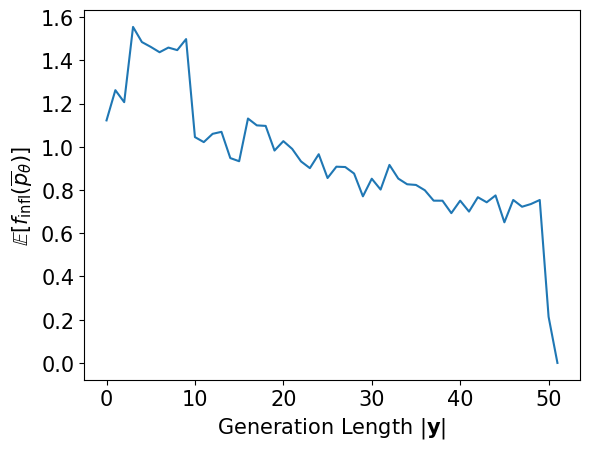

In [33]:
import matplotlib.pyplot as plt

end = mem_vals.shape[1]

plt.plot(np.arange(0, end), np.nanmean(mem_vals, axis=0))
plt.ylabel(r"$\mathbb{E}[f_{\text{infl}}(\overline{p}_\theta)]$", fontsize=15)
plt.xlabel(r'Generation Length $|\mathbf{y}|$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("gen_len_analysis.pdf", bbox_inches="tight")

/tmp/ipykernel_3494428/3257229161.py:4: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(mem_vals, axis=0)


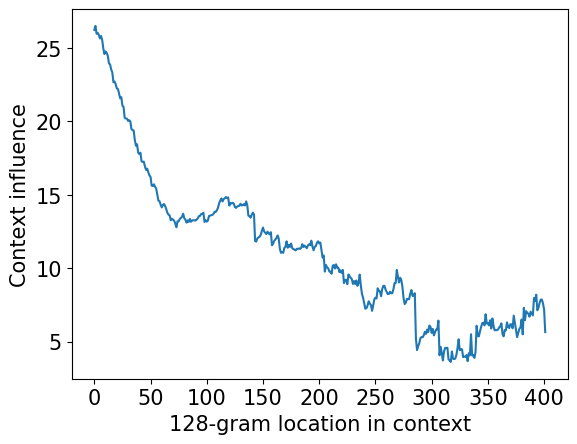

In [63]:
import matplotlib.pyplot as plt

end = 500
mean_vals = np.nanmean(mem_vals, axis=0)
plt.plot(np.arange(0, end), mean_vals[:end])
plt.xlabel("128-gram location in context", fontsize=15)
plt.ylabel(r'Context influence', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig("n_gram_loc_analysis.pdf", bbox_inches="tight")

In [33]:
result_dict = evaluator.evaluate(predictions, references, documents)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/james/memorization_and_hallucination/venv/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are exp

rouge1_fmeasure -> 24.09
rouge1_precision -> 27.13
rouge1_recall -> 24.11
rouge2_fmeasure -> 6.88
rouge2_precision -> 7.75
rouge2_recall -> 6.97
rougeL_fmeasure -> 16.92
rougeL_precision -> 19.08
rougeL_recall -> 17.03
rougeLsum_fmeasure -> 19.71
rougeLsum_precision -> 22.32
rougeLsum_recall -> 19.68
bertscore_precision -> 72.52
bertscore_recall -> 72.96
bertscore_f1 -> 72.70
factkb -> 54.08
alignscore -> 42.83


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    token=access_token,
    cache_dir=cache_dir,
    local_files_only=True,
    #device_map="auto",
    #max_memory = {0: "0GB", 1: "0GB", 2: "35GB", 3: "35GB", 4: "35GB", 5: "35GB", 6: "35GB", 7: "35GB"}
    ).to(DEVICE)

In [63]:
data, response = test_set[53], predictions[53]
n = 2
t = 20
temperature=0.8
stop_token_ids = [tokenizer.eos_token_id,
                      tokenizer.pad_token_id,
                     ]

context_unaware_tokenized_input = tokenizer(template_empty_input(data, dataset_name), return_tensors="pt", padding=True)
context_aware_tokenized_input = tokenizer(template_input(data, dataset_name), return_tensors="pt", padding=True)

ensemble, n_grams = partition_n_gram(data, tokenizer, dataset_name, n)
ensemble_context_aware_tokenized_input = tokenizer(ensemble, return_tensors="pt", padding=True)
ensemble_context_aware_tokenized_input_ids = ensemble_context_aware_tokenized_input.input_ids.to(DEVICE)

response_tokenized_input = tokenizer(response, return_tensors="pt")

context_aware_input_ids = context_aware_tokenized_input.input_ids.to(DEVICE)
response_input_ids = response_tokenized_input.input_ids.to(DEVICE)
context_unaware_input_ids = context_unaware_tokenized_input.input_ids.to(DEVICE)

N = context_aware_input_ids.shape[0]
priv_context_aware_input_ids = torch.cat([context_aware_input_ids,
                              response_input_ids[:, :t].repeat(N, 1)],
                             dim=1)
batch_size = 32
with torch.no_grad():
    proj_output, pub_output, ensemble_proj_output = calc_distributions(model, 
                                                                          context_aware_input_ids, 
                                                                          response_input_ids,
                                                                          lambd,
                                                                          temperature,
                                                                          stop_token_ids,
                                                                          min_new_tokens,
                                                                          t,
                                                                          batch_size,
                                                                          ensemble_context_aware_tokenized_input_ids)
ids = torch.nonzero(pub_output)  
mem_vals = calc_group_memorization(proj_output[ids], ensemble_proj_output[:, ids].squeeze(-1), response_input_ids[:, t].cpu())

In [35]:
tokenizer.decode(response_input_ids[-1, 18])

' aliens'

In [65]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def value_to_color(value, min_value, max_value):
    """ Map a float value to a color based on its position in the value range. """
    norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
    cmap = plt.get_cmap('coolwarm')  # You can choose different colormaps
    return mcolors.to_hex(cmap(norm(value)))

# Normalize and colorize
min_value = min(mem_vals)
max_value = max(mem_vals)

colors = [value_to_color(val, min_value, max_value) for val in mem_vals]

In [66]:
from IPython.display import HTML

def colorize_text_html(vals, colors):
    colored_text = ', '.join(
        f'<span style="color: {color};">{tokenizer.decode(input_ids)}</span>'
        for input_ids, color in zip(vals, colors)
    )
    return f'<p>{colored_text}</p>'

colored_text_html = colorize_text_html(n_grams[47:141], colors[47:141])
#colored_text_html = colorize_text_html(n_grams, colors)
HTML(colored_text_html)

In [75]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.colors import HexColor, black
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

def create_colored_pdf(vals, colors, filename):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    # Set starting position
    x, y = 50, height - 50
    line_height = 14

    # Draw text with colors
    for input_ids, color in zip(vals, colors):
        word = tokenizer.decode(input_ids)
        color = HexColor(color)

        # Set color and draw text
        c.setFillColor(color)
        c.drawString(x, y, word)
        x += c.stringWidth(word + ' ', 'Helvetica', 12)

        # Move to next line if needed
        if x > width - 80:
            x = 50
            y -= line_height

    # Draw the color scale image in PDF
    #c.drawImage(color_scale_image, scale_x, scale_y, width=scale_width, height=scale_height)
    
    c.save()

# Create the PDF
create_colored_pdf(n_grams[47:141], colors[47:141], "2_gram_colored_text.pdf")

In [ ]:
c = canvas.Canvas("colored_text.pdf", pagesize=letter)

# Draw color scale
scale_width = 5 * inch
scale_height = 0.5 * inch
scale_x = 50
scale_y = 50
c.setFillColor(black)
c.rect(scale_x, scale_y, scale_width, scale_height, fill=0)

# Create color scale using matplotlib
fig, ax = plt.subplots(figsize=(5, 0.5), dpi=80)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
cmap = plt.get_cmap('coolwarm')
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, cax=ax, orientation='horizontal')
cb.ax.tick_params(labelsize=10)
#cb.ax.set_title('Value Scale', fontsize=10)
#plt.show()
# Save color scale to an image
color_scale_image = "color_scale.pdf"
plt.savefig(color_scale_image, bbox_inches='tight', pad_inches=0)
plt.close(fig)